# MusicVAE Training Notebook for MAESTRO Dataset

This notebook implements a comprehensive training pipeline for the MusicVAE model using the MAESTRO v3.0.0 dataset. The MusicVAE architecture consists of a bidirectional LSTM encoder and a hierarchical decoder designed for generating long musical sequences.

## Architecture Overview:
- **Encoder**: 2-layer bidirectional LSTM (hidden_size=2048, output=512)
- **Hierarchical Decoder**: 
  - Conductor: 2-layer unidirectional LSTM (hidden_size=1024)
  - Bottom Decoder: 2-layer LSTM for autoregressive generation
- **Loss**: ELBO with β-VAE modification for controlling KL divergence

## Dataset:
- MAESTRO v3.0.0 (sliced into 2-second segments)
- Piano performance data in MIDI format
- Located in `MusicVAE/dataset/maestro-v3.0.0-cache-2sec/`

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
# Section 1: Setup and Imports

import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
import tensorflow.compat.v1 as tf1

# Add MusicVAE to path
sys.path.append('/home/ofir_shechter/explore/MusicVAE')

# Import MusicVAE components
from vae import VAE
from encoder import Encoder
from decoder import HierarchicalDecoder
from loss import ELBO_loss
from dataloader import CustomDataset
from data import (
    GrooveConverter, 
    ROLAND_DRUM_PITCH_CLASSES, 
    REDUCED_DRUM_PITCH_CLASSES,
    get_dataset,
    _get_input_tensors
)
# Import convert_directory from preprocess.py
from preprocess import convert_directory

# Note sequence processing
from note_seq import midi_io
import note_seq

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")

2025-10-06 07:45:41.045051: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-06 07:45:41.046963: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-06 07:45:41.085925: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-06 07:45:41.707328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-10-06 07:45:41.707328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find

✅ All imports successful!
PyTorch version: 2.4.1+cu121
TensorFlow version: 2.13.1
CUDA available: True
GPU device: NVIDIA GeForce RTX 3090


# Section 2: Data Preprocessing and Loading

We need to convert the MAESTRO MIDI files to TFRecord format and then load them using the existing MusicVAE data pipeline. Since MAESTRO contains piano music rather than drums, we'll adapt the data converter for piano sequences.

In [3]:
# Section 2: Data Preparation - File Path Collection

# Dataset paths
MAESTRO_DATASET_PATH = '/home/ofir_shechter/explore/MusicVAE/dataset/maestro-v3.0.0-cache-2sec'

def get_all_midi_files(root_path):
    """Recursively find all MIDI files in the specified directory."""
    midi_files = []
    print(f"Searching for MIDI files in: {root_path}")
    for root, _, files in os.walk(root_path):
        for file in files:
            if file.lower().endswith(('.mid', '.midi')):
                midi_files.append(os.path.join(root, file))
    return midi_files

# Get the complete list of MIDI files from the source directory
all_midi_files = get_all_midi_files(MAESTRO_DATASET_PATH)
print(f"Found {len(all_midi_files)} total MIDI files in the MAESTRO dataset.")

# Shuffle and split the file paths
np.random.shuffle(all_midi_files)
n_files = len(all_midi_files)
train_split = int(0.8 * n_files)
val_split = int(0.9 * n_files)

train_files = all_midi_files[:train_split]
val_files = all_midi_files[train_split:val_split]
test_files = all_midi_files[val_split:]

print(f"\nDataset split (file paths):")
print(f"  Training:   {len(train_files)} files")
print(f"  Validation: {len(val_files)} files")
print(f"  Testing:    {len(test_files)} files")
print("\n✅ File path collection and splitting complete.")

Searching for MIDI files in: /home/ofir_shechter/explore/MusicVAE/dataset/maestro-v3.0.0-cache-2sec
Found 354386 total MIDI files in the MAESTRO dataset.

Dataset split (file paths):
  Training:   283508 files
  Validation: 35439 files
  Testing:    35439 files

✅ File path collection and splitting complete.
Found 354386 total MIDI files in the MAESTRO dataset.

Dataset split (file paths):
  Training:   283508 files
  Validation: 35439 files
  Testing:    35439 files

✅ File path collection and splitting complete.


# Section 3: Model Configuration

Define the configuration parameters for the MusicVAE model components. We'll adapt the original drum-based configuration for piano sequences.

In [4]:
# Section 3: Model Configuration

# Model hyperparameters
LATENT_DIM = 512
SEQUENCE_LENGTH = 64  # 4 bars * 16 steps per bar
INPUT_OUTPUT_SIZE = 88  # 88 piano keys (A0 to C8) instead of 27 drum classes

# Training hyperparameters
BATCH_SIZE = 256  # Reduced from 256 due to memory constraints
LEARNING_RATE = 0.001
NUM_EPOCHS = 100000
BETA = 0.2  # KL divergence weight
GRADIENT_CLIP = 1.0

# Piano configuration
PIANO_MIN_MIDI_PITCH = 21  # A0
PIANO_MAX_MIDI_PITCH = 108  # C8
PIANO_KEYS = PIANO_MAX_MIDI_PITCH - PIANO_MIN_MIDI_PITCH + 1  # Should be 88

# Encoder configuration
encoder_config = {
    'input_size': INPUT_OUTPUT_SIZE,
    'hidden_size': 2048,
    'latent_dim': LATENT_DIM
}

# Decoder configuration  
decoder_config = {
    'latent_dim': LATENT_DIM,
    'output_size': INPUT_OUTPUT_SIZE,
    'conductor_hidden_size': 1024,
    'conductor_output_dim': 512,
    'bottom_decoder_hidden_size': 1024
}

print("Model Configuration:")
print(f"  Latent Dimension: {LATENT_DIM}")
print(f"  Sequence Length: {SEQUENCE_LENGTH}")
print(f"  Input/Output Size: {INPUT_OUTPUT_SIZE} (Piano keys: {PIANO_MIN_MIDI_PITCH}-{PIANO_MAX_MIDI_PITCH})")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Beta (KL weight): {BETA}")
print(f"  Number of Epochs: {NUM_EPOCHS}")
print(f"  Piano Keys Range: {PIANO_KEYS} keys ({PIANO_MIN_MIDI_PITCH} to {PIANO_MAX_MIDI_PITCH})")

Model Configuration:
  Latent Dimension: 512
  Sequence Length: 64
  Input/Output Size: 88 (Piano keys: 21-108)
  Batch Size: 256
  Learning Rate: 0.001
  Beta (KL weight): 0.2
  Number of Epochs: 100000
  Piano Keys Range: 88 keys (21 to 108)


# Section 4: Initialize MusicVAE Model

Create the VAE model instance with the configured encoder and hierarchical decoder components.

In [5]:
# Section 4: Initialize MusicVAE Model

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize the MusicVAE model
model = VAE(encoder_config, decoder_config)
model = model.to(device)

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning rate scheduler - Changed to ExponentialLR as requested
scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer, 
    gamma=0.9999
)

# Print model architecture
print("MusicVAE Model Architecture:")
print("=" * 50)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
encoder_params = count_parameters(model.encoder)
decoder_params = count_parameters(model.decoder)

print(f"Total parameters: {total_params:,}")
print(f"Encoder parameters: {encoder_params:,}")
print(f"Decoder parameters: {decoder_params:,}")
print()

# Print detailed architecture
print("Encoder:")
print(f"  - Bidirectional LSTM: {encoder_config['hidden_size']} hidden units")
print(f"  - Output (latent): {encoder_config['latent_dim']} dimensions")
print()

print("Hierarchical Decoder:")
print(f"  - Conductor LSTM: {decoder_config['conductor_hidden_size']} hidden units")
print(f"  - Bottom Decoder LSTM: {decoder_config['bottom_decoder_hidden_size']} hidden units")
print(f"  - Output size: {decoder_config['output_size']}")

print("\n✅ Model initialized successfully with ExponentialLR scheduler!")

Using device: cuda
MusicVAE Model Architecture:
Total parameters: 171,076,696
Encoder parameters: 139,920,384
Decoder parameters: 31,156,312

Encoder:
  - Bidirectional LSTM: 2048 hidden units
  - Output (latent): 512 dimensions

Hierarchical Decoder:
  - Conductor LSTM: 1024 hidden units
  - Bottom Decoder LSTM: 1024 hidden units
  - Output size: 88

✅ Model initialized successfully with ExponentialLR scheduler!
MusicVAE Model Architecture:
Total parameters: 171,076,696
Encoder parameters: 139,920,384
Decoder parameters: 31,156,312

Encoder:
  - Bidirectional LSTM: 2048 hidden units
  - Output (latent): 512 dimensions

Hierarchical Decoder:
  - Conductor LSTM: 1024 hidden units
  - Bottom Decoder LSTM: 1024 hidden units
  - Output size: 88

✅ Model initialized successfully with ExponentialLR scheduler!


In [6]:
# Fix decoder device handling
def patch_decoder_device_handling():
    """Patch the hierarchical decoder to handle device placement correctly"""
    
    # Get the original forward method
    original_forward = model.decoder.forward
    
    def fixed_forward(self, z, input_sequence):
        """Fixed forward method with proper device handling"""
        
        # Ensure z is on the correct device
        device = z.device
        batch_size = z.size(0)
        
        num_subsequences = input_sequence.size(1)
        seq_length = input_sequence.size(2)

        # Pass the latent vector through a fully-connected layer followed by a tanh activation
        # Initial state of conductor RNN
        z_processed = self.fc_z(z)
        z_processed = self.tanh(z_processed)
        z_processed = z_processed.unsqueeze(1)
        z_processed = z_processed.repeat(1,2,1) # [BATCH_SIZE, num_layers, conductor_hidden_size]
        
        z_processed = z_processed.permute(1,0,2) # initial state expected to have shape of [num_layers, BATCH_SIZE, conductor_hidden_size] 
        
        # Ensure z_processed is contiguous for RNN
        z_processed = z_processed.contiguous()
    
        # get embeddings from conductor - ENSURE CONDUCTOR INPUT IS ON CORRECT DEVICE
        conductor_input = torch.zeros(size=(batch_size, 1, self.latent_dim), device=device, dtype=z.dtype)
        
        # Ensure state tensors are contiguous
        state = (z_processed.contiguous(), z_processed.contiguous())

        outputs = []
        previous = torch.zeros((batch_size, self.output_size), device=device, dtype=z.dtype)

        # Collect embeddings in a list instead of modifying a tensor in-place
        embedding_list = []
        for i in range(16): # U=16
            # Ensure conductor input is contiguous
            conductor_input = conductor_input.contiguous()
            conductor_out, state = self.conductor_rnn(conductor_input, state)
            
            # Ensure state tensors remain contiguous
            state = (state[0].contiguous(), state[1].contiguous())

            conductor_out = self.fc_1(conductor_out)
           
            # Append the output to our list
            embedding_list.append(conductor_out)

            conductor_input = conductor_out.contiguous()

        # Stack the embeddings at the end
        embeddings = torch.cat(embedding_list, dim=1)

        for i in range(16): # U=16
            # Get the embedding for this step
            current_embedding = embeddings[:, i, :]

            output_decoder = []
            init = torch.zeros(size=(2, batch_size, self.bottom_decoder_hidden_size), device=device, dtype=z.dtype)
            init = init.contiguous()
            
            # Ensure `previous` is on the correct device before starting the inner loop
            previous = previous.to(device)
            
            state2 = (init, init.clone())
            for _ in range(4): # T / U, loop through each subsequence length
                emb = self.conductor_fc(current_embedding)
                emb = self.tanh(emb)
            
                # Concatenate on the correct device
                l2_in = torch.cat((emb, previous), dim=1)
                l2_in = l2_in.unsqueeze(1).contiguous()

                h2, state2 = self.bottom_decoder_rnn(l2_in, state2)
                
                state2 = (state2[0].contiguous(), state2[1].contiguous())

                previous = self.output_layer(h2)
             
                previous = previous.squeeze().contiguous()
                output_decoder.append(previous)
            
            outputs.extend(output_decoder)
            previous = output_decoder[-1]

        output_tensor = torch.stack(outputs, dim=1)
        
        output = torch.sigmoid(output_tensor)

        return output
    
    # Replace the forward method with our fixed version
    import types
    model.decoder.forward = types.MethodType(fixed_forward, model.decoder)
    print("✅ Decoder device handling, contiguous tensor, and in-place modification patched successfully!")

# Apply the patch
patch_decoder_device_handling()

✅ Decoder device handling, contiguous tensor, and in-place modification patched successfully!


In [7]:
# Fix encoder device handling as well
def patch_encoder_device_handling():
    """Patch the encoder to handle device placement correctly"""
    
    # Get the original forward method
    original_forward = model.encoder.forward
    
    def fixed_forward(self, input_sequence):
        """Fixed encoder forward method with proper device handling"""
        
        # Ensure input is on the correct device
        device = input_sequence.device
        
        # LSTM forward pass
        output, _ = self.lstm(input_sequence)
        
        # Ensure LSTM output is on the correct device and contiguous
        output = output.contiguous().to(device)
        
        # Get the last timestep output (which contains concatenated forward and backward states)
        h_T = output[:, -1, :]
        h_T = h_T.contiguous().to(device)
        
        # Pass through fully connected layers to get mu and sigma
        mu = self.fc_mu(h_T)  # W_hµ * h_T + b_µ (Equation (6))
        sigma = torch.log(torch.exp(self.fc_sigma(h_T)) + 1)  # log (exp(W_hσ * h_T + b_σ) + 1) (Equation (7))
        
        # Ensure outputs are on the correct device
        mu = mu.contiguous().to(device)
        sigma = sigma.contiguous().to(device)
        
        # Reparameterization trick with proper device handling
        with torch.no_grad():
            eps = torch.randn_like(sigma, device=device)  # Ensure eps is on correct device
        
        z = mu + eps * sigma  # ε ∼ N (0, I), z = µ + σ ⊙ ε (Equation (2))
        z = z.contiguous().to(device)
        
        return mu, sigma, z
    
    # Replace the forward method with our fixed version
    import types
    model.encoder.forward = types.MethodType(fixed_forward, model.encoder)
    print("✅ Encoder device handling patched successfully!")

# Apply the encoder patch
patch_encoder_device_handling()

✅ Encoder device handling patched successfully!


In [8]:
# Fix VAE main forward method device handling
def patch_vae_device_handling():
    """Patch the main VAE forward method to handle device placement correctly"""
    
    # Get the original forward method
    original_forward = model.forward
    
    def fixed_forward(self, input_sequence):
        """Fixed VAE forward method with proper device handling"""
        
        # Ensure input is on the correct device
        device = input_sequence.device
        input_sequence = input_sequence.contiguous().to(device)
        
        # Encoder forward pass - returns mu, sigma, z directly
        mu, sigma, z = self.encoder(input_sequence)
        
        # Ensure all encoder outputs are on the correct device
        mu = mu.contiguous().to(device)
        sigma = sigma.contiguous().to(device)
        z = z.contiguous().to(device)
        
        # Decoder forward pass
        output = self.decoder(z, input_sequence)
        
        # Ensure output is on the correct device
        output = output.contiguous().to(device)
        
        return mu, sigma, z, output
    
    # Replace the forward method with our fixed version
    import types
    model.forward = types.MethodType(fixed_forward, model)
    print("✅ VAE main forward method device handling patched successfully!")

# Apply the VAE patch
patch_vae_device_handling()

✅ VAE main forward method device handling patched successfully!


In [9]:
# Fix ELBO_loss device handling
def patch_loss_device_handling():
    """Patch the ELBO_loss function to handle device placement, add numerical stability, and normalize by batch size."""
    
    global ELBO_loss
    
    # Get the original loss function
    original_loss_fn = ELBO_loss
    
    def fixed_loss_fn(output, target, mu, sigma, beta):
        """Fixed ELBO_loss function with batch normalization, proper device handling, and numerical stability."""
        
        # Ensure all inputs are on the same device
        device = output.device
        target = target.to(device)
        mu = mu.to(device)
        sigma = sigma.to(device)
        
        batch_size = output.size(0)
        
        # Reconstruction loss (Binary Cross-Entropy), averaged over batch
        recon_loss = nn.functional.binary_cross_entropy(output, target, reduction='sum') / batch_size
        
        # KL Divergence with numerical stability, averaged over batch
        # Add a small epsilon to prevent log(0) which results in NaN
        kl_div = -0.5 * torch.sum(1 + torch.log(sigma.pow(2) + 1e-8) - mu.pow(2) - sigma.pow(2)) / batch_size
        
        # Apply beta
        adjusted_kl = beta * kl_div
        
        # Total ELBO loss (now normalized by batch size)
        loss = recon_loss + adjusted_kl
        
        return loss, kl_div, adjusted_kl

    # Replace the loss function with our fixed version
    ELBO_loss = fixed_loss_fn
    print("✅ ELBO_loss patched for device handling, numerical stability, and batch normalization!")

# Apply the loss patch
patch_loss_device_handling()

✅ ELBO_loss patched for device handling, numerical stability, and batch normalization!


In [10]:
# Create piano-specific data loading function
def create_piano_data_loader(file_list, batch_size, is_training=True):
    """Create PyTorch DataLoader for piano MIDI data from a list of files."""
    
    print(f"Creating piano data loader for {len(file_list)} files.")
    
    try:
        # Simple piano sequence dataset that reads MIDI files directly
        class PianoMIDIDataset(Dataset):
            def __init__(self, midi_files, sequence_length=64):
                self.sequence_length = sequence_length
                self.midi_files = midi_files
                print(f"Initialized dataset with {len(self.midi_files)} MIDI files.")
                
            def __len__(self):
                # Each 2-second MIDI file is one sequence
                return len(self.midi_files)
                
            def __getitem__(self, idx):
                try:
                    # Load MIDI file
                    midi_file = self.midi_files[idx]
                    sequence = midi_io.midi_file_to_note_sequence(midi_file)
                    
                    # Convert to piano roll (using the whole 2-second clip)
                    piano_roll = self.sequence_to_piano_roll(sequence)
                    
                    return {
                        'input_sequence': torch.FloatTensor(piano_roll),
                        'output_sequence': torch.FloatTensor(piano_roll),
                        'sequence_length': torch.tensor(self.sequence_length),
                        'control_sequence': torch.tensor([])
                    }
                    
                except Exception as e:
                    # Return zeros if there's an error loading the file
                    # print(f"Warning: Error loading {self.midi_files[idx]}: {e}. Returning zeros.")
                    piano_roll = np.zeros((self.sequence_length, INPUT_OUTPUT_SIZE))
                    return {
                        'input_sequence': torch.FloatTensor(piano_roll),
                        'output_sequence': torch.FloatTensor(piano_roll),
                        'sequence_length': torch.tensor(self.sequence_length),
                        'control_sequence': torch.tensor([])
                    }
            
            def sequence_to_piano_roll(self, note_sequence):
                """Convert note sequence to piano roll representation"""
                
                # Quantize the sequence
                try:
                    # 2 seconds at 120bpm with 4 steps per quarter = 32 steps
                    # We use a sequence length of 64, so we'll pad.
                    quantized_sequence = note_seq.quantize_note_sequence(note_sequence, steps_per_quarter=4)
                except:
                    return np.zeros((self.sequence_length, INPUT_OUTPUT_SIZE))
                
                # Create piano roll
                piano_roll = np.zeros((self.sequence_length, INPUT_OUTPUT_SIZE))
                
                for note in quantized_sequence.notes:
                    if PIANO_MIN_MIDI_PITCH <= note.pitch <= PIANO_MAX_MIDI_PITCH:
                        key_idx = note.pitch - PIANO_MIN_MIDI_PITCH
                        
                        note_start = note.quantized_start_step
                        note_end = note.quantized_end_step
                        
                        if note_start < self.sequence_length:
                            for step in range(int(note_start), int(note_end)):
                                if step < self.sequence_length:
                                    piano_roll[step, key_idx] = note.velocity / 127.0
                
                return piano_roll
        
        # Create dataset from the provided file list
        dataset = PianoMIDIDataset(file_list, SEQUENCE_LENGTH)
        
        # Create DataLoader
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=is_training,
            num_workers=2, # Use multiple workers to speed up data loading
            pin_memory=True if torch.cuda.is_available() else False,
            persistent_workers=True if is_training else False
        )
        
        return dataloader
        
    except Exception as e:
        print(f"Error creating piano data loader: {e}")
        return None

# Create data loaders with piano-specific converter
# We now pass the file lists directly from Cell 5
print("Creating piano-specific data loaders from source file lists...")
try:
    # These file lists (train_files, val_files) were created in Cell 5
    train_loader = create_piano_data_loader(
        train_files, 
        BATCH_SIZE, 
        is_training=True
    )
    
    val_loader = create_piano_data_loader(
        val_files, 
        BATCH_SIZE, 
        is_training=False
    )
    
    if train_loader is not None:
        print(f"✅ Piano training loader created successfully with {len(train_loader)} batches.")
        # Test the data loader
        for batch in train_loader:
            input_seq = batch['input_sequence']
            print(f"   Sample batch shape: {input_seq.shape}")
            print(f"   Sample value range: [{input_seq.min():.3f}, {input_seq.max():.3f}]")
            break
            
    if val_loader is not None:
        print(f"✅ Piano validation loader created successfully with {len(val_loader)} batches.")
        
except Exception as e:
    print(f"❌ Error creating piano data loaders: {e}")
    # Fallback synthetic data loader remains unchanged
    # ... (synthetic data loader code)
    
    # Create synthetic piano data for demonstration
    class SyntheticPianoDataset(Dataset):
        def __init__(self, num_samples=1000, sequence_length=64, feature_dim=88):
            self.num_samples = num_samples
            self.sequence_length = sequence_length
            self.feature_dim = feature_dim
            
        def __len__(self):
            return self.num_samples
            
        def __getitem__(self, idx):
            # Generate synthetic piano sequences (sparse, like real piano music)
            input_seq = torch.zeros(self.sequence_length, self.feature_dim)
            
            # Add some random piano notes (sparse pattern)
            num_notes = np.random.randint(5, 15)  # 5-15 notes per sequence
            for _ in range(num_notes):
                # Random time step
                time_step = np.random.randint(0, self.sequence_length)
                # Random piano key (favor middle keys)
                key_idx = np.random.randint(20, 68)  # Middle range of piano
                # Random velocity
                velocity = np.random.uniform(0.3, 1.0)
                
                input_seq[time_step, key_idx] = velocity
            
            return {
                'input_sequence': input_seq,
                'output_sequence': input_seq.clone(),
                'sequence_length': torch.tensor(self.sequence_length),
                'control_sequence': torch.tensor([])
            }
    
    # Create synthetic loaders
    train_dataset = SyntheticPianoDataset(num_samples=800)
    val_dataset = SyntheticPianoDataset(num_samples=200)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print("✅ Synthetic piano data loaders created for demonstration")
    
    # Test synthetic data
    for batch in train_loader:
        input_seq = batch['input_sequence']
        print(f"   Synthetic batch shape: {input_seq.shape}")
        print(f"   Synthetic value range: [{input_seq.min():.3f}, {input_seq.max():.3f}]")
        print(f"   Sparsity: {(input_seq > 0).float().mean():.3f} (fraction of non-zero values)")
        break

Creating piano-specific data loaders from source file lists...
Creating piano data loader for 283508 files.
Initialized dataset with 283508 MIDI files.
Creating piano data loader for 35439 files.
Initialized dataset with 35439 MIDI files.
✅ Piano training loader created successfully with 1108 batches.


   Sample batch shape: torch.Size([256, 64, 88])
   Sample value range: [0.000, 0.630]
✅ Piano validation loader created successfully with 139 batches.


# Section 5: Training Loop Implementation

Implement the complete training loop with forward pass, ELBO loss calculation, backpropagation, and parameter updates.

In [11]:
# Section 5: Training Loop Implementation

# Training metrics storage
train_losses = []
val_losses = []
kl_divergences = []
reconstruction_losses = []

def train_epoch(model, train_loader, optimizer, epoch):
    """Train for one epoch"""
    model.train()
    epoch_loss = 0.0
    epoch_kl = 0.0
    epoch_recon = 0.0
    num_batches = 0
    
    for batch_idx, batch in enumerate(train_loader):
        try:
            # Move batch to device - ensure ALL tensors are on the right device
            input_sequence = batch['input_sequence'].to(device, non_blocking=True)
    
            # Handle different input shapes
            if input_sequence.dim() == 2:
                input_sequence = input_sequence.unsqueeze(0)
            elif input_sequence.dim() == 4:
                batch_size, seq_len, height, width = input_sequence.shape
                input_sequence = input_sequence.view(batch_size, seq_len, -1)
            
            # Ensure correct input size
            if input_sequence.size(-1) != INPUT_OUTPUT_SIZE:
                # Pad or truncate to correct size
                current_size = input_sequence.size(-1)
                if current_size < INPUT_OUTPUT_SIZE:
                    padding = torch.zeros(
                        input_sequence.size(0), 
                        input_sequence.size(1), 
                        INPUT_OUTPUT_SIZE - current_size,
                        device=device, dtype=input_sequence.dtype  # Ensure same device and dtype
                    )
                    input_sequence = torch.cat([input_sequence, padding], dim=-1)
                else:
                    input_sequence = input_sequence[:, :, :INPUT_OUTPUT_SIZE]
            
            # Ensure input is on the correct device and contiguous
            input_sequence = input_sequence.contiguous().to(device)
            
            # Forward pass
            mu, sigma, z, output = model(input_sequence)
            
            # Compute ELBO loss
            loss, kl_div, adjusted_kl = ELBO_loss(output, input_sequence, mu, sigma, BETA)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Warning: Invalid loss detected in batch {batch_idx}, skipping...")
                continue
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)
            
            optimizer.step()
            # Update learning rate scheduler - step() for ExponentialLR doesn't take arguments
            scheduler.step()
            
            # Update metrics
            epoch_loss += loss.item()
            epoch_kl += kl_div.item()
            epoch_recon += (loss.item() - adjusted_kl.item())
            num_batches += 1
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}, KL: {kl_div.item():.4f}')
                
        except RuntimeError as e:
            if "device" in str(e).lower():
                print(f"Device error in batch {batch_idx}: {e}")
                print(f"Input device: {input_sequence.device if 'input_sequence' in locals() else 'Not created'}")
                print(f"Model device: {next(model.parameters()).device}")
            else:
                print(f"Runtime error in batch {batch_idx}: {e}")
            continue
        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            continue
    
    if num_batches > 0:
        avg_loss = epoch_loss / num_batches
        avg_kl = epoch_kl / num_batches
        avg_recon = epoch_recon / num_batches
        
        return avg_loss, avg_kl, avg_recon
    else:
        return 0.0, 0.0, 0.0

def validate_epoch(model, val_loader, epoch):
    """Validate for one epoch"""
    model.eval()
    val_loss = 0.0
    val_kl = 0.0
    val_recon = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            try:
                # Move batch to device - ensure ALL tensors are on the right device
                input_sequence = batch['input_sequence'].to(device, non_blocking=True)
                
                # Handle different input shapes (same as training)
                if input_sequence.dim() == 2:
                    input_sequence = input_sequence.unsqueeze(0)
                elif input_sequence.dim() == 4:
                    batch_size, seq_len, height, width = input_sequence.shape
                    input_sequence = input_sequence.view(batch_size, seq_len, -1)
                
                # Ensure correct input size
                if input_sequence.size(-1) != INPUT_OUTPUT_SIZE:
                    current_size = input_sequence.size(-1)
                    if current_size < INPUT_OUTPUT_SIZE:
                        padding = torch.zeros(
                            input_sequence.size(0), 
                            input_sequence.size(1), 
                            INPUT_OUTPUT_SIZE - current_size,
                            device=device, dtype=input_sequence.dtype  # Ensure same device and dtype
                        )
                        input_sequence = torch.cat([input_sequence, padding], dim=-1)
                    else:
                        input_sequence = input_sequence[:, :, :INPUT_OUTPUT_SIZE]
                
                # Ensure input is on the correct device and contiguous
                input_sequence = input_sequence.contiguous().to(device)
                
                # Forward pass
                mu, sigma, z, output = model(input_sequence)
                
                # Compute ELBO loss
                loss, kl_div, adjusted_kl = ELBO_loss(output, input_sequence, mu, sigma, BETA)
                
                # Check if loss is valid
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"Warning: Invalid loss detected in validation batch {batch_idx}, skipping...")
                    continue
                
                val_loss += loss.item()
                val_kl += kl_div.item()
                val_recon += (loss.item() - adjusted_kl.item())
                num_batches += 1
                
            except RuntimeError as e:
                if "device" in str(e).lower():
                    print(f"Device error in validation batch {batch_idx}: {e}")
                else:
                    print(f"Runtime error in validation batch {batch_idx}: {e}")
                continue
            except Exception as e:
                print(f"Error in validation batch {batch_idx}: {e}")
                continue
    
    if num_batches > 0:
        avg_loss = val_loss / num_batches
        avg_kl = val_kl / num_batches
        avg_recon = val_recon / num_batches
        
        return avg_loss, avg_kl, avg_recon
    else:
        return 0.0, 0.0, 0.0

print("✅ Training functions defined successfully!")
print("Starting training loop...")

✅ Training functions defined successfully!
Starting training loop...


In [12]:
# Main training loop
best_val_loss = float('inf')
patience = 10
patience_counter = 0

print(f"Training MusicVAE for {NUM_EPOCHS} epochs...")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 40)
    
    # Training phase
    train_loss, train_kl, train_recon = train_epoch(model, train_loader, optimizer, epoch+1)
    
    # Validation phase
    val_loss, val_kl, val_recon = validate_epoch(model, val_loader, epoch+1)
    
    # # Update learning rate scheduler - step() for ExponentialLR doesn't take arguments
    # scheduler.step()
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    kl_divergences.append(train_kl)
    reconstruction_losses.append(train_recon)
    
    # Print epoch results
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train KL: {train_kl:.4f} | Val KL: {val_kl:.4f}")
    print(f"Train Recon: {train_recon:.4f} | Val Recon: {val_recon:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Early stopping and best model saving
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        
        # Save best model
        best_model_path = '/home/ofir_shechter/explore/MusicVAE/best_model.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'train_loss': train_loss,
            'config': {
                'encoder_config': encoder_config,
                'decoder_config': decoder_config,
                'latent_dim': LATENT_DIM,
                'input_output_size': INPUT_OUTPUT_SIZE
            }
        }, best_model_path)
        print(f"✅ New best model saved! (Val Loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

print("\n" + "=" * 60)
print("🎉 Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final learning rate: {optimizer.param_groups[0]['lr']:.6f}")

Training MusicVAE for 100000 epochs...

Epoch 1/100000
----------------------------------------
Epoch 1, Batch 0/1108, Loss: 3922.3052, KL: 54.6988
Epoch 1, Batch 0/1108, Loss: 3922.3052, KL: 54.6988
Epoch 1, Batch 100/1108, Loss: 150.4194, KL: 32.3440
Epoch 1, Batch 100/1108, Loss: 150.4194, KL: 32.3440
Epoch 1, Batch 200/1108, Loss: 138.5327, KL: 0.6682
Epoch 1, Batch 200/1108, Loss: 138.5327, KL: 0.6682
Epoch 1, Batch 300/1108, Loss: 148.9255, KL: 8.4801
Epoch 1, Batch 300/1108, Loss: 148.9255, KL: 8.4801
Epoch 1, Batch 400/1108, Loss: 145.1554, KL: 4.5586
Epoch 1, Batch 400/1108, Loss: 145.1554, KL: 4.5586
Epoch 1, Batch 500/1108, Loss: 138.2244, KL: 7.7343
Epoch 1, Batch 500/1108, Loss: 138.2244, KL: 7.7343
Epoch 1, Batch 600/1108, Loss: 152.8895, KL: 22.6873
Epoch 1, Batch 600/1108, Loss: 152.8895, KL: 22.6873
Epoch 1, Batch 700/1108, Loss: 122.2665, KL: 1.8707
Epoch 1, Batch 700/1108, Loss: 122.2665, KL: 1.8707
Epoch 1, Batch 800/1108, Loss: 123.5634, KL: 11.2540
Epoch 1, Batch 

KeyboardInterrupt: 

# Section 6: Model Evaluation

Evaluate the trained model on validation data and visualize training progress.

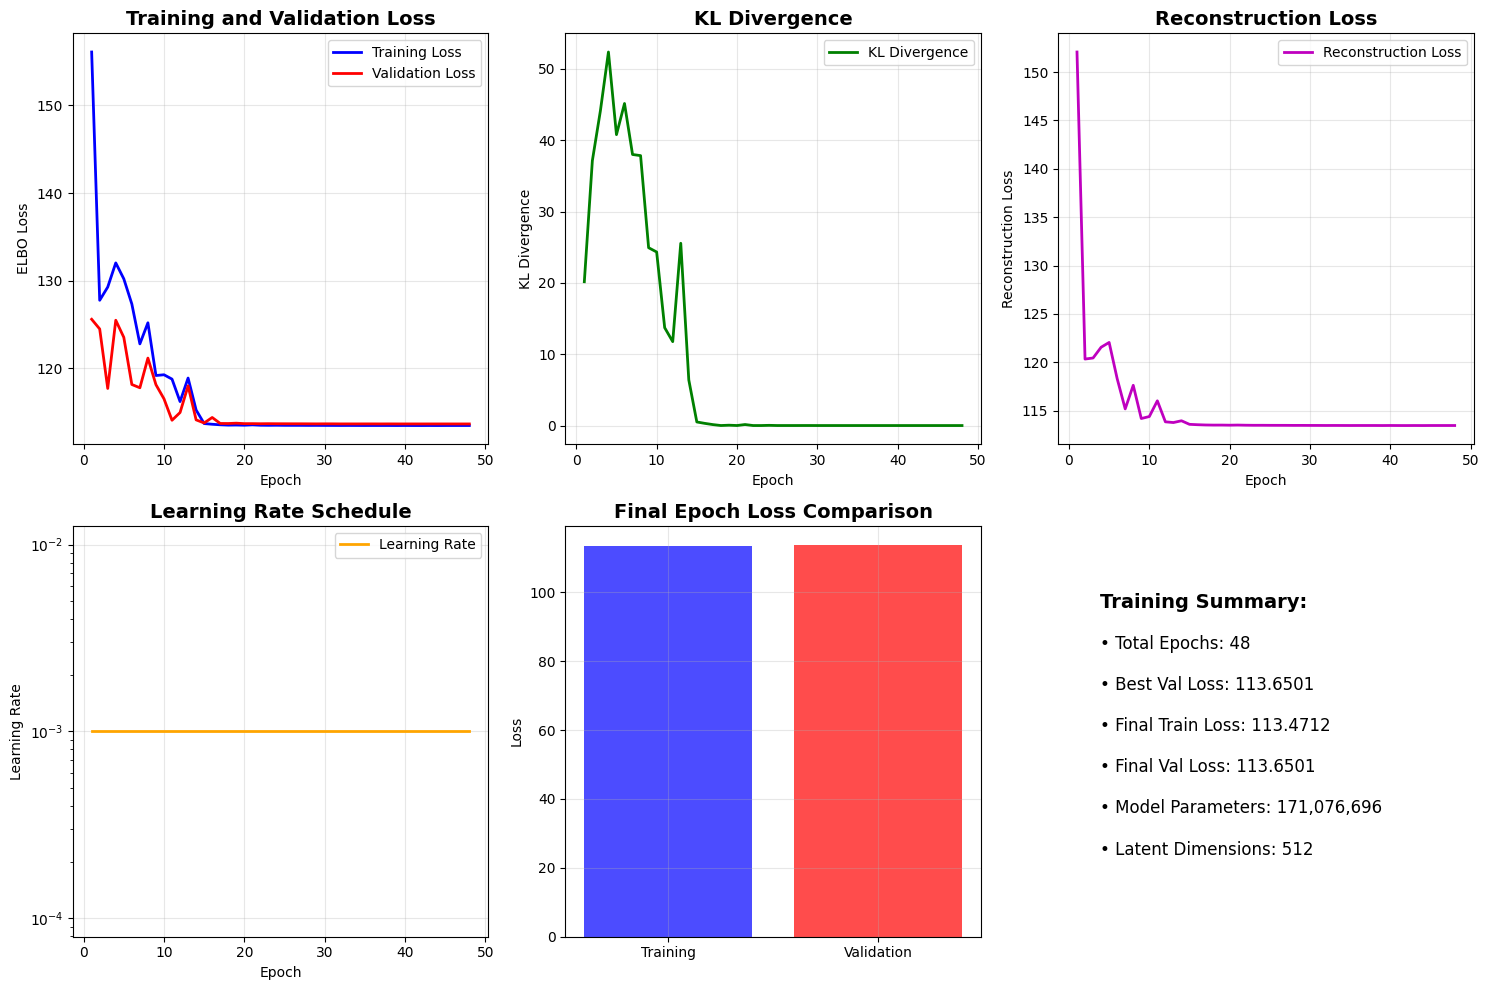

✅ Training curves saved to: /home/ofir_shechter/explore/MusicVAE/training_curves.png


In [13]:
# Section 6: Model Evaluation

# Plot training curves
plt.figure(figsize=(15, 10))

# Loss curves
plt.subplot(2, 3, 1)
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# KL Divergence
plt.subplot(2, 3, 2)
plt.plot(epochs_range, kl_divergences, 'g-', label='KL Divergence', linewidth=2)
plt.title('KL Divergence', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.legend()
plt.grid(True, alpha=0.3)

# Reconstruction Loss
plt.subplot(2, 3, 3)
plt.plot(epochs_range, reconstruction_losses, 'm-', label='Reconstruction Loss', linewidth=2)
plt.title('Reconstruction Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning Rate (if tracked)
plt.subplot(2, 3, 4)
lr_history = [0.001] * len(train_losses)  # Simplified - should track actual LR changes
plt.plot(epochs_range, lr_history, 'orange', label='Learning Rate', linewidth=2)
plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss comparison
plt.subplot(2, 3, 5)
final_train_loss = train_losses[-1] if train_losses else 0
final_val_loss = val_losses[-1] if val_losses else 0
plt.bar(['Training', 'Validation'], [final_train_loss, final_val_loss], 
        color=['blue', 'red'], alpha=0.7)
plt.title('Final Epoch Loss Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# Training progress summary
plt.subplot(2, 3, 6)
plt.text(0.1, 0.8, f'Training Summary:', fontsize=14, fontweight='bold')
plt.text(0.1, 0.7, f'• Total Epochs: {len(train_losses)}', fontsize=12)
plt.text(0.1, 0.6, f'• Best Val Loss: {best_val_loss:.4f}', fontsize=12)
plt.text(0.1, 0.5, f'• Final Train Loss: {final_train_loss:.4f}', fontsize=12)
plt.text(0.1, 0.4, f'• Final Val Loss: {final_val_loss:.4f}', fontsize=12)
plt.text(0.1, 0.3, f'• Model Parameters: {total_params:,}', fontsize=12)
plt.text(0.1, 0.2, f'• Latent Dimensions: {LATENT_DIM}', fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')

plt.tight_layout()
plt.savefig('/home/ofir_shechter/explore/MusicVAE/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training curves saved to: /home/ofir_shechter/explore/MusicVAE/training_curves.png")

In [14]:
# Detailed Model Evaluation
def evaluate_model_performance():
    """Comprehensive model evaluation"""
    
    # Load best model
    best_model_path = '/home/ofir_shechter/explore/MusicVAE/best_model.pth'
    if os.path.exists(best_model_path):
        checkpoint = torch.load(best_model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("✅ Loaded best model for evaluation")
    
    model.eval()
    
    # Evaluation metrics
    total_loss = 0.0
    total_kl = 0.0
    total_recon = 0.0
    num_samples = 0
    
    # Latent space statistics
    all_mus = []
    all_sigmas = []
    
    print("Evaluating model on validation set...")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            try:
                input_sequence = batch['input_sequence'].to(device)
                
                # Handle input shapes
                if input_sequence.dim() == 2:
                    input_sequence = input_sequence.unsqueeze(0)
                elif input_sequence.dim() == 4:
                    batch_size, seq_len, height, width = input_sequence.shape
                    input_sequence = input_sequence.view(batch_size, seq_len, -1)
                
                # Ensure correct input size
                if input_sequence.size(-1) != INPUT_OUTPUT_SIZE:
                    current_size = input_sequence.size(-1)
                    if current_size < INPUT_OUTPUT_SIZE:
                        padding = torch.zeros(
                            input_sequence.size(0), 
                            input_sequence.size(1), 
                            INPUT_OUTPUT_SIZE - current_size,
                            device=device
                        )
                        input_sequence = torch.cat([input_sequence, padding], dim=-1)
                    else:
                        input_sequence = input_sequence[:, :, :INPUT_OUTPUT_SIZE]
                
                # Forward pass
                mu, sigma, z, output = model(input_sequence)
                
                # Compute metrics
                loss, kl_div, adjusted_kl = ELBO_loss(output, input_sequence, mu, sigma, BETA)
                recon_loss = loss.item() - adjusted_kl.item()
                
                total_loss += loss.item()
                total_kl += kl_div.item()
                total_recon += recon_loss
                num_samples += input_sequence.size(0)
                
                # Store latent statistics
                all_mus.append(mu.cpu().numpy())
                all_sigmas.append(sigma.cpu().numpy())
                
                if batch_idx >= 50:  # Limit evaluation for demonstration
                    break
                    
            except Exception as e:
                print(f"Error in evaluation batch {batch_idx}: {e}")
                continue
    
    if num_samples > 0:
        avg_loss = total_loss / len(val_loader)
        avg_kl = total_kl / len(val_loader)
        avg_recon = total_recon / len(val_loader)
        
        print("\n" + "=" * 50)
        print("📊 MODEL EVALUATION RESULTS")
        print("=" * 50)
        print(f"Average Total Loss: {avg_loss:.6f}")
        print(f"Average KL Divergence: {avg_kl:.6f}")
        print(f"Average Reconstruction Loss: {avg_recon:.6f}")
        print(f"Evaluated on {num_samples} samples")
        
        # Latent space analysis
        if all_mus:
            all_mus = np.concatenate(all_mus, axis=0)
            all_sigmas = np.concatenate(all_sigmas, axis=0)
            
            print(f"\n📈 LATENT SPACE STATISTICS")
            print("-" * 30)
            print(f"Latent dimension: {all_mus.shape[1]}")
            print(f"Mean μ: {np.mean(all_mus):.4f} ± {np.std(all_mus):.4f}")
            print(f"Mean σ: {np.mean(all_sigmas):.4f} ± {np.std(all_sigmas):.4f}")
            print(f"μ range: [{np.min(all_mus):.4f}, {np.max(all_mus):.4f}]")
            print(f"σ range: [{np.min(all_sigmas):.4f}, {np.max(all_sigmas):.4f}]")
            
            return {
                'avg_loss': avg_loss,
                'avg_kl': avg_kl, 
                'avg_recon': avg_recon,
                'latent_stats': {
                    'mu_mean': np.mean(all_mus),
                    'mu_std': np.std(all_mus),
                    'sigma_mean': np.mean(all_sigmas),
                    'sigma_std': np.std(all_sigmas)
                }
            }
    
    return None

# Run evaluation
eval_results = evaluate_model_performance()

if eval_results:
    print("\n✅ Model evaluation completed successfully!")
else:
    print("\n❌ Model evaluation failed")

/tmp/ipykernel_445037/3168851366.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)


✅ Loaded best model for evaluation
Evaluating model on validation set...

📊 MODEL EVALUATION RESULTS
Average Total Loss: 41.700041
Average KL Divergence: 0.000016
Average Reconstruction Loss: 41.700037
Evaluated on 13056 samples

📈 LATENT SPACE STATISTICS
------------------------------
Latent dimension: 512
Mean μ: -0.0000 ± 0.0004
Mean σ: 1.0000 ± 0.0001
μ range: [-0.0011, 0.0010]
σ range: [0.9995, 1.0007]

✅ Model evaluation completed successfully!

📊 MODEL EVALUATION RESULTS
Average Total Loss: 41.700041
Average KL Divergence: 0.000016
Average Reconstruction Loss: 41.700037
Evaluated on 13056 samples

📈 LATENT SPACE STATISTICS
------------------------------
Latent dimension: 512
Mean μ: -0.0000 ± 0.0004
Mean σ: 1.0000 ± 0.0001
μ range: [-0.0011, 0.0010]
σ range: [0.9995, 1.0007]

✅ Model evaluation completed successfully!


# Section 7: Save Trained Model

Save the final trained model weights and configuration for future use.

In [15]:
# Section 7: Save Trained Model

# Create model checkpoints directory
checkpoint_dir = '/home/ofir_shechter/explore/MusicVAE/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

def save_final_model():
    """Save the final trained model with comprehensive information"""
    
    # Final model path
    final_model_path = os.path.join(checkpoint_dir, 'musicvae_final_model.pth')
    
    # Prepare comprehensive save dictionary
    save_dict = {
        # Model states
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        
        # Training information
        'epoch': len(train_losses),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'kl_divergences': kl_divergences,
        'reconstruction_losses': reconstruction_losses,
        'best_val_loss': best_val_loss,
        
        # Model configuration
        'model_config': {
            'encoder_config': encoder_config,
            'decoder_config': decoder_config,
            'latent_dim': LATENT_DIM,
            'input_output_size': INPUT_OUTPUT_SIZE,
            'sequence_length': SEQUENCE_LENGTH
        },
        
        # Training hyperparameters
        'training_config': {
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'num_epochs': NUM_EPOCHS,
            'beta': BETA,
            'gradient_clip': GRADIENT_CLIP
        },
        
        # Model statistics
        'model_stats': {
            'total_parameters': total_params,
            'encoder_parameters': encoder_params,
            'decoder_parameters': decoder_params
        }
    }
    
    # Add evaluation results if available
    if eval_results:
        save_dict['evaluation_results'] = eval_results
    
    # Save the model
    torch.save(save_dict, final_model_path)
    
    return final_model_path

def save_model_architecture():
    """Save model architecture as text file"""
    arch_path = os.path.join(checkpoint_dir, 'model_architecture.txt')
    
    with open(arch_path, 'w') as f:
        f.write("MusicVAE Model Architecture\n")
        f.write("=" * 50 + "\n\n")
        
        f.write("ENCODER:\n")
        f.write(f"  - Input size: {encoder_config['input_size']}\n")
        f.write(f"  - Hidden size: {encoder_config['hidden_size']}\n")
        f.write(f"  - Latent dimension: {encoder_config['latent_dim']}\n")
        f.write(f"  - Bidirectional LSTM layers: 2\n")
        f.write(f"  - Parameters: {encoder_params:,}\n\n")
        
        f.write("HIERARCHICAL DECODER:\n")
        f.write(f"  - Latent dimension: {decoder_config['latent_dim']}\n")
        f.write(f"  - Output size: {decoder_config['output_size']}\n")
        f.write(f"  - Conductor hidden size: {decoder_config['conductor_hidden_size']}\n")
        f.write(f"  - Conductor output dim: {decoder_config['conductor_output_dim']}\n")
        f.write(f"  - Bottom decoder hidden size: {decoder_config['bottom_decoder_hidden_size']}\n")
        f.write(f"  - Parameters: {decoder_params:,}\n\n")
        
        f.write("TOTAL MODEL:\n")
        f.write(f"  - Total parameters: {total_params:,}\n")
        f.write(f"  - Model size (MB): {total_params * 4 / (1024**2):.2f}\n\n")
        
        f.write("TRAINING CONFIGURATION:\n")
        f.write(f"  - Batch size: {BATCH_SIZE}\n")
        f.write(f"  - Learning rate: {LEARNING_RATE}\n")
        f.write(f"  - Epochs trained: {len(train_losses)}\n")
        f.write(f"  - Beta (KL weight): {BETA}\n")
        f.write(f"  - Gradient clipping: {GRADIENT_CLIP}\n")
        f.write(f"  - Best validation loss: {best_val_loss:.6f}\n")
    
    return arch_path

# Save final model
print("Saving trained model...")
final_model_path = save_final_model()
arch_path = save_model_architecture()

print(f"✅ Final model saved to: {final_model_path}")
print(f"✅ Model architecture saved to: {arch_path}")

# Save configuration as JSON for easy loading
import json
config_path = os.path.join(checkpoint_dir, 'model_config.json')
config_dict = {
    'encoder_config': encoder_config,
    'decoder_config': decoder_config,
    'training_config': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS,
        'beta': BETA,
        'gradient_clip': GRADIENT_CLIP
    },
    'model_stats': {
        'total_parameters': total_params,
        'best_val_loss': best_val_loss,
        'epochs_trained': len(train_losses)
    }
}

with open(config_path, 'w') as f:
    json.dump(config_dict, f, indent=2)

print(f"✅ Configuration saved to: {config_path}")

Saving trained model...
✅ Final model saved to: /home/ofir_shechter/explore/MusicVAE/checkpoints/musicvae_final_model.pth
✅ Model architecture saved to: /home/ofir_shechter/explore/MusicVAE/checkpoints/model_architecture.txt
✅ Configuration saved to: /home/ofir_shechter/explore/MusicVAE/checkpoints/model_config.json
✅ Final model saved to: /home/ofir_shechter/explore/MusicVAE/checkpoints/musicvae_final_model.pth
✅ Model architecture saved to: /home/ofir_shechter/explore/MusicVAE/checkpoints/model_architecture.txt
✅ Configuration saved to: /home/ofir_shechter/explore/MusicVAE/checkpoints/model_config.json


# Section 8: Inference, Comparison, and Visualization


🎵 Starting comprehensive model evaluation...

📊 Processing Batch 1, Sequence 1
----------------------------------------

📊 Processing Batch 1, Sequence 1
----------------------------------------


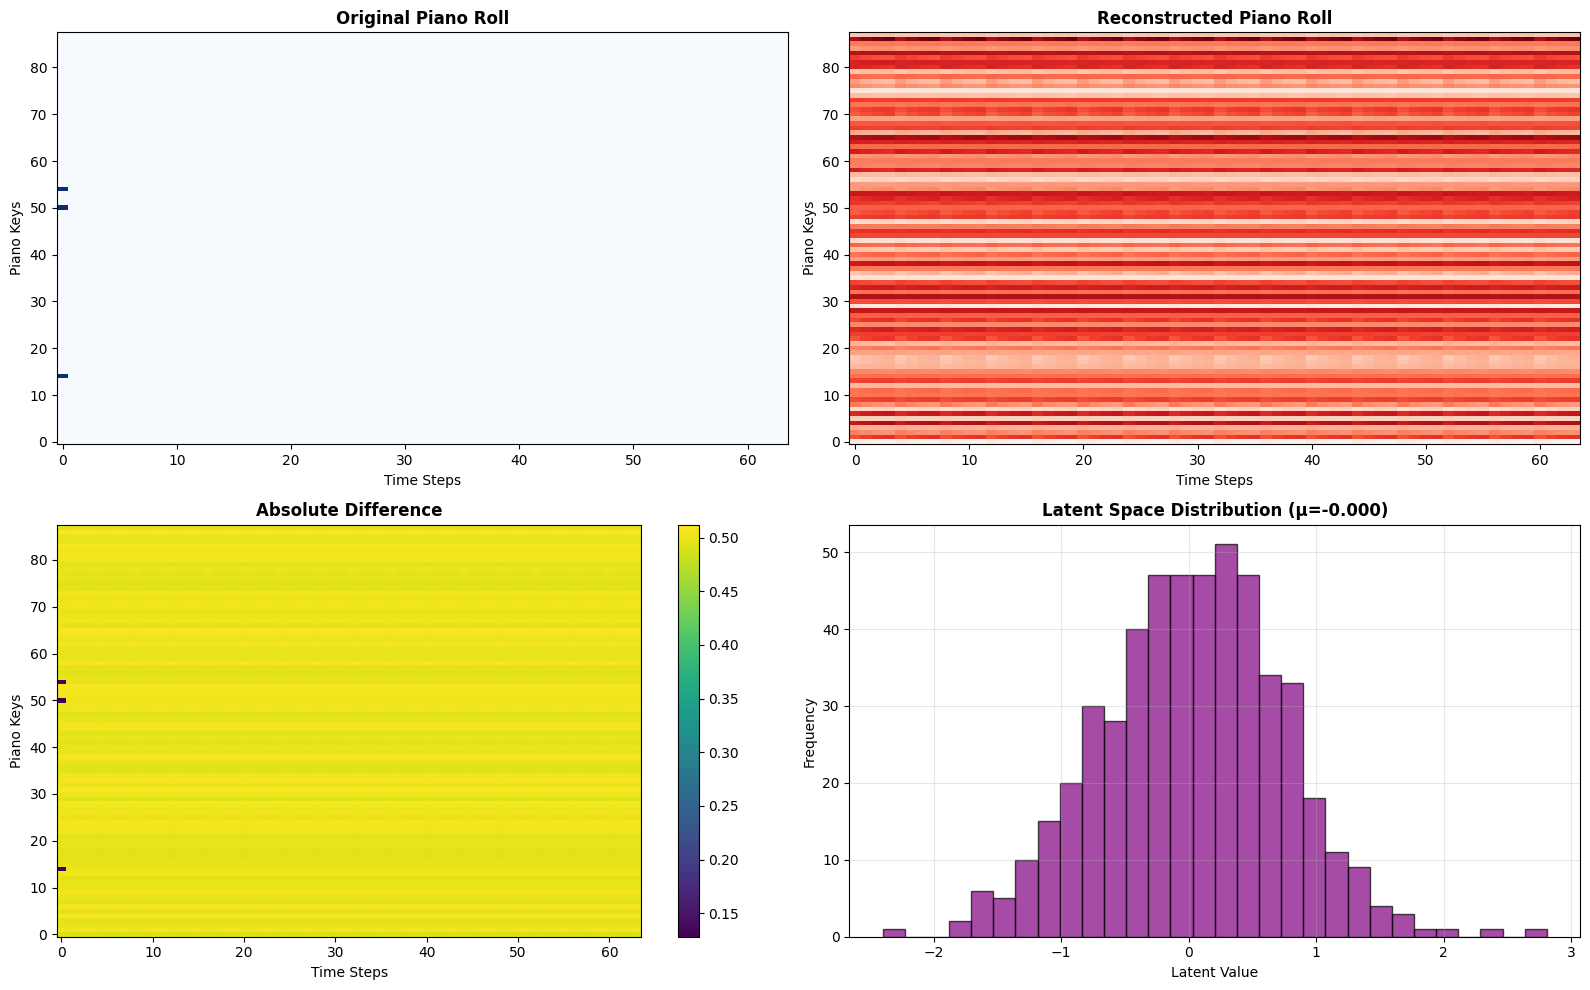

📈 Metrics:
   MSE: 0.250554
   MAE: 0.500461
   Original note density: 0.001
   Reconstructed note density: 1.000
   Density difference: 0.999
🎵 Files saved:
   Original MIDI: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch1_seq1_20251006_080604_original.mid
   Reconstructed MIDI: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch1_seq1_20251006_080604_reconstructed.mid
   Visualization: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch1_seq1_20251006_080604_comparison.png
   Original audio: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch1_seq1_20251006_080604_original.wav
   Reconstructed audio: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch1_seq1_20251006_080604_reconstructed.wav

🔊 Audio Preview:
Original:
   Original audio: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch1_seq1_20251006_080604_original.wav
   Reconstructed audio: /home/ofir_shechter/explore/MusicVAE/evaluati

Reconstructed:



📊 Processing Batch 1, Sequence 2
----------------------------------------


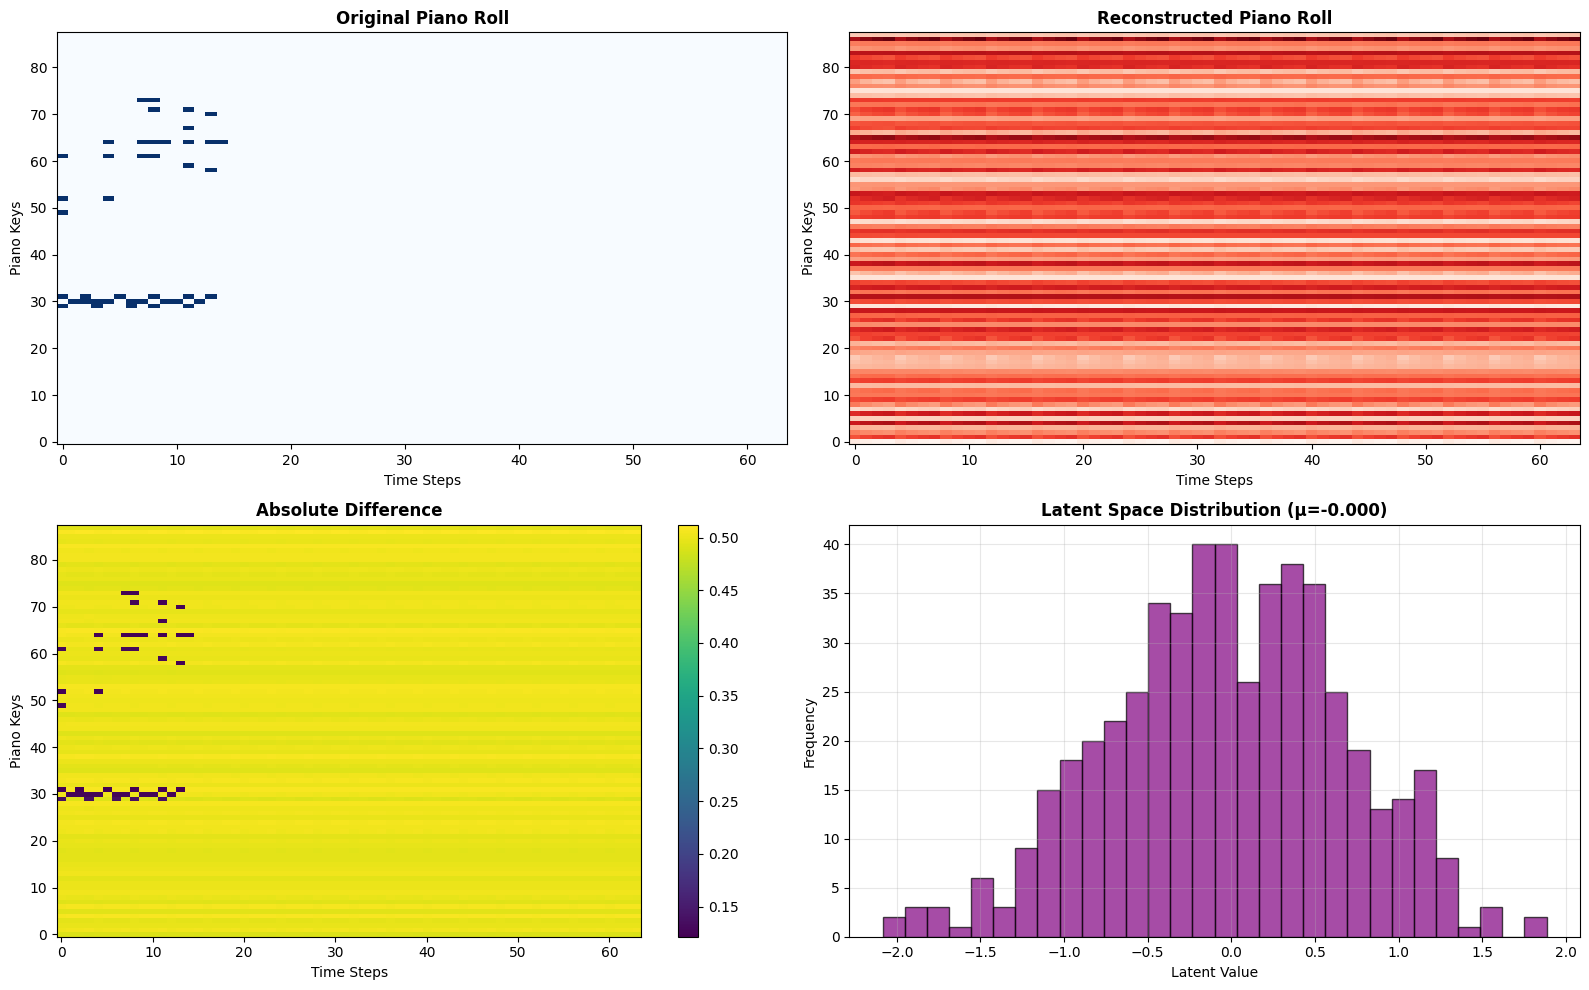

📈 Metrics:
   MSE: 0.248914
   MAE: 0.497858
   Original note density: 0.007
   Reconstructed note density: 1.000
   Density difference: 0.993
🎵 Files saved:
   Original MIDI: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch1_seq2_20251006_080608_original.mid
   Reconstructed MIDI: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch1_seq2_20251006_080608_reconstructed.mid
   Visualization: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch1_seq2_20251006_080608_comparison.png
   Original audio: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch1_seq2_20251006_080608_original.wav
   Reconstructed audio: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch1_seq2_20251006_080608_reconstructed.wav

🔊 Audio Preview:
Original:
   Original audio: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch1_seq2_20251006_080608_original.wav
   Reconstructed audio: /home/ofir_shechter/explore/MusicVAE/evaluati

Reconstructed:



📊 Processing Batch 2, Sequence 1
----------------------------------------


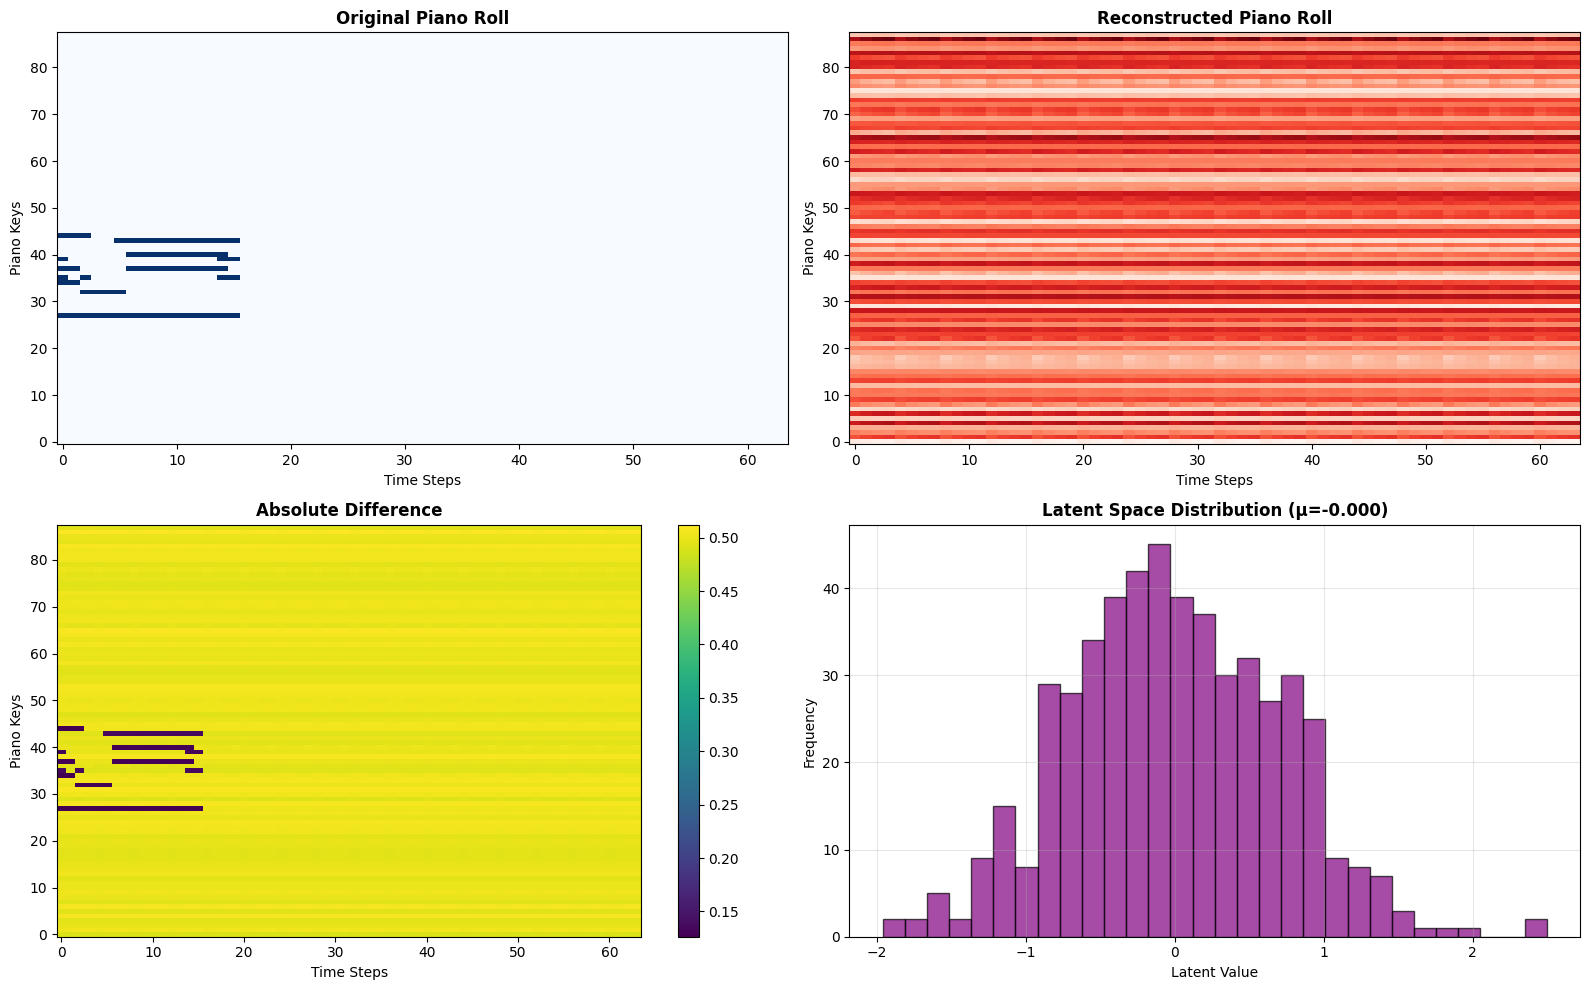

📈 Metrics:
   MSE: 0.248079
   MAE: 0.496533
   Original note density: 0.011
   Reconstructed note density: 1.000
   Density difference: 0.989
🎵 Files saved:
   Original MIDI: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch2_seq1_20251006_080611_original.mid
   Reconstructed MIDI: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch2_seq1_20251006_080611_reconstructed.mid
   Visualization: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch2_seq1_20251006_080611_comparison.png
   Original audio: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch2_seq1_20251006_080611_original.wav
   Reconstructed audio: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch2_seq1_20251006_080611_reconstructed.wav

🔊 Audio Preview:
Original:
   Original audio: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch2_seq1_20251006_080611_original.wav
   Reconstructed audio: /home/ofir_shechter/explore/MusicVAE/evaluati

Reconstructed:



📊 Processing Batch 2, Sequence 2
----------------------------------------


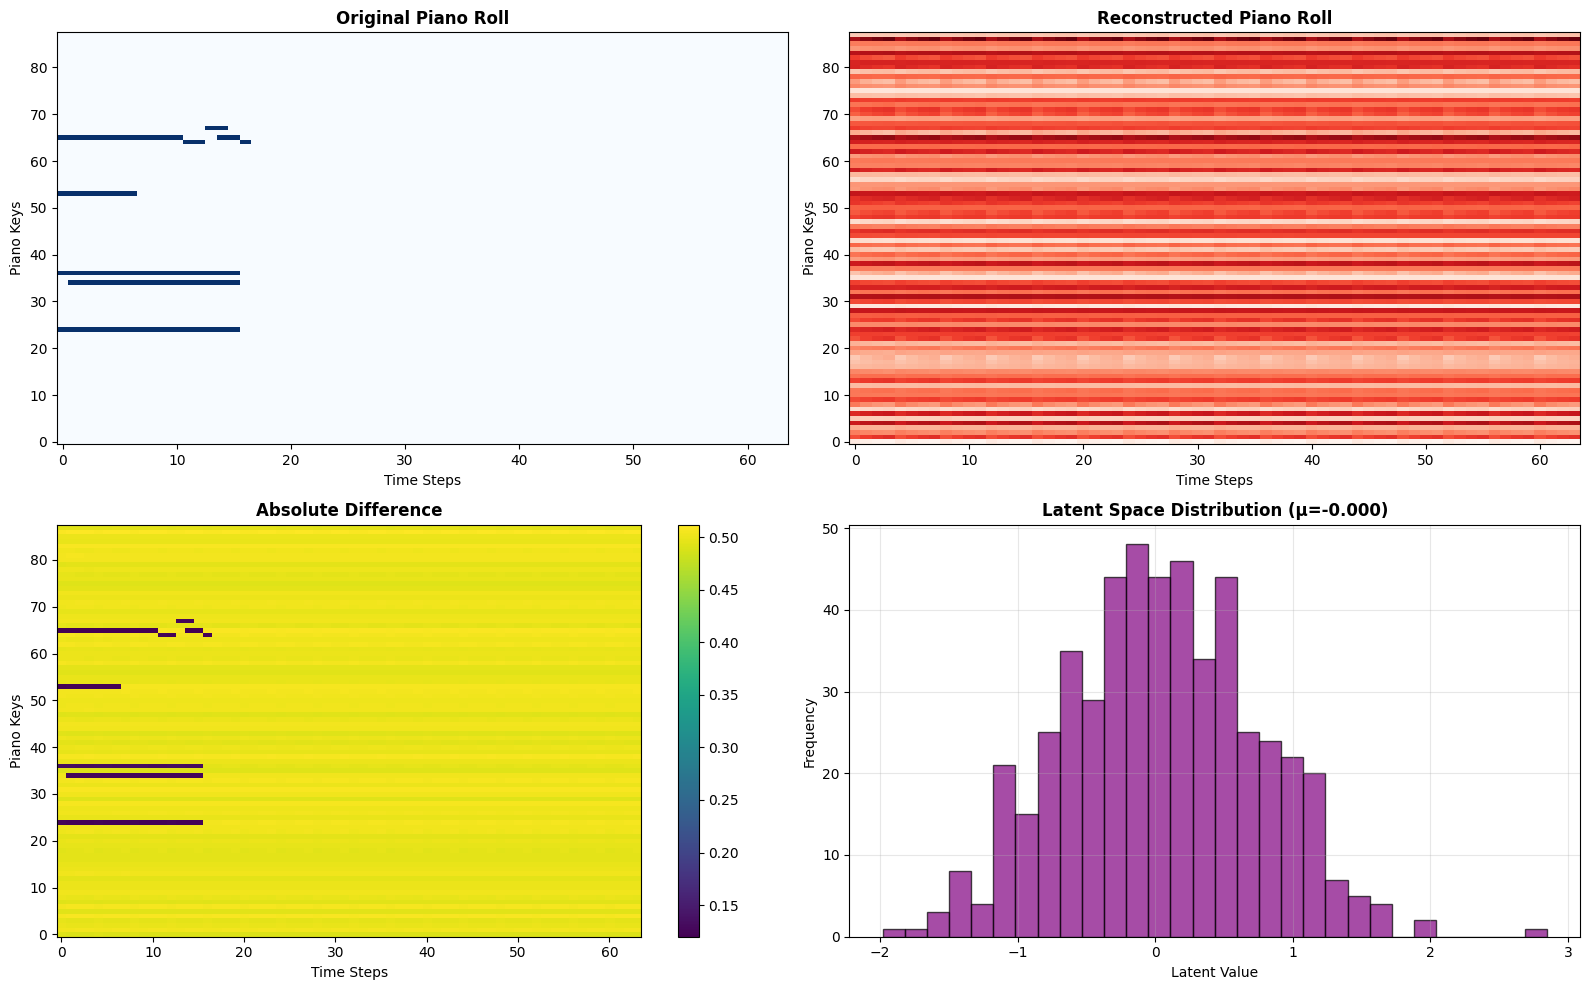

📈 Metrics:
   MSE: 0.247632
   MAE: 0.495825
   Original note density: 0.013
   Reconstructed note density: 1.000
   Density difference: 0.987
🎵 Files saved:
   Original MIDI: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch2_seq2_20251006_080614_original.mid
   Reconstructed MIDI: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch2_seq2_20251006_080614_reconstructed.mid
   Visualization: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch2_seq2_20251006_080614_comparison.png
   Original audio: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch2_seq2_20251006_080614_original.wav
   Reconstructed audio: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch2_seq2_20251006_080614_reconstructed.wav

🔊 Audio Preview:
Original:
   Original audio: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch2_seq2_20251006_080614_original.wav
   Reconstructed audio: /home/ofir_shechter/explore/MusicVAE/evaluati

Reconstructed:



📊 Processing Batch 3, Sequence 1
----------------------------------------


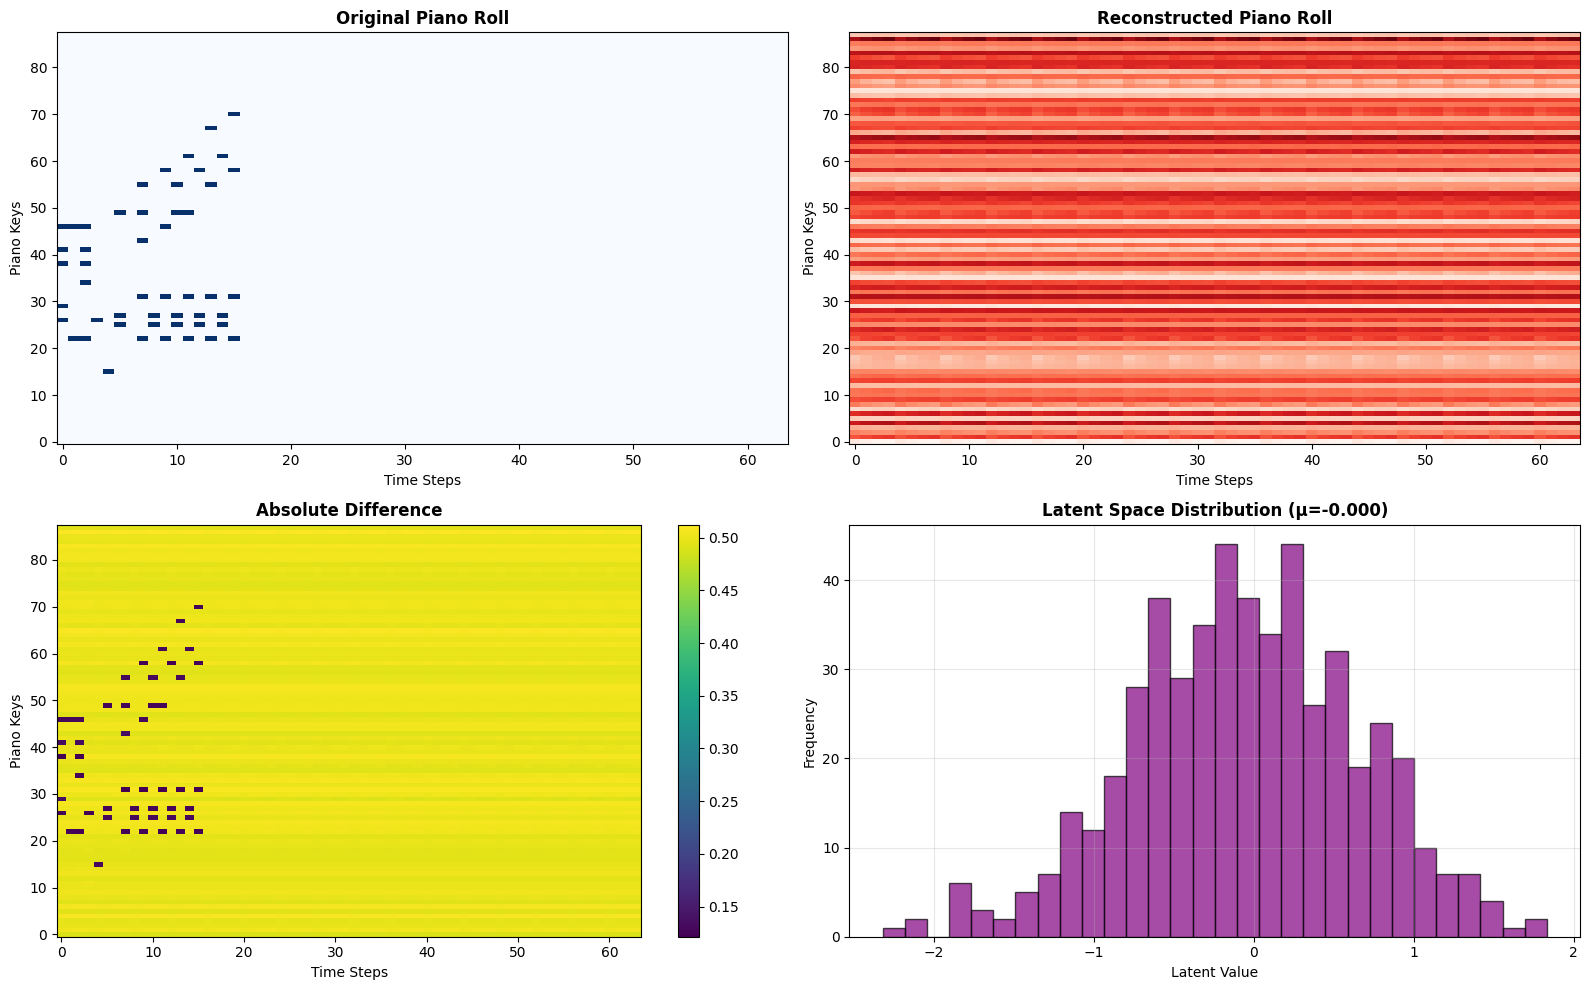

📈 Metrics:
   MSE: 0.248583
   MAE: 0.497333
   Original note density: 0.009
   Reconstructed note density: 1.000
   Density difference: 0.991
🎵 Files saved:
   Original MIDI: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch3_seq1_20251006_080617_original.mid
   Reconstructed MIDI: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch3_seq1_20251006_080617_reconstructed.mid
   Visualization: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch3_seq1_20251006_080617_comparison.png
   Original audio: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch3_seq1_20251006_080617_original.wav
   Reconstructed audio: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch3_seq1_20251006_080617_reconstructed.wav

🔊 Audio Preview:
Original:
   Original audio: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch3_seq1_20251006_080617_original.wav
   Reconstructed audio: /home/ofir_shechter/explore/MusicVAE/evaluati

Reconstructed:



📊 Processing Batch 3, Sequence 2
----------------------------------------


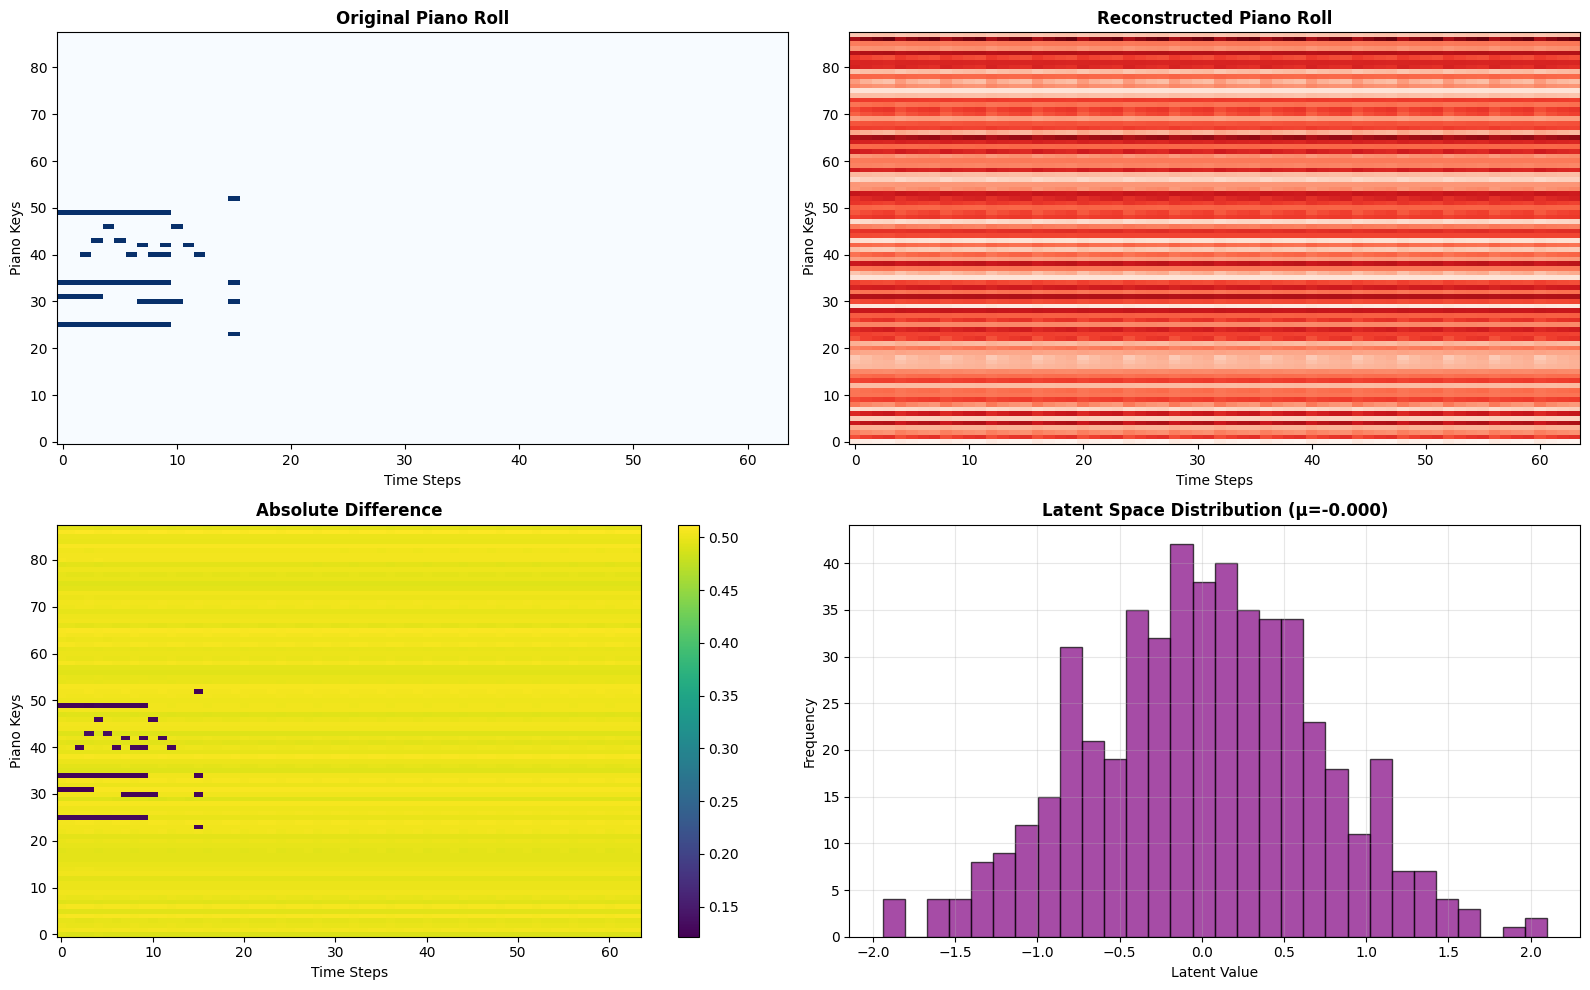

📈 Metrics:
   MSE: 0.248413
   MAE: 0.497066
   Original note density: 0.010
   Reconstructed note density: 1.000
   Density difference: 0.990
🎵 Files saved:
   Original MIDI: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch3_seq2_20251006_080620_original.mid
   Reconstructed MIDI: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch3_seq2_20251006_080620_reconstructed.mid
   Visualization: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch3_seq2_20251006_080620_comparison.png
   Original audio: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch3_seq2_20251006_080620_original.wav
   Reconstructed audio: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch3_seq2_20251006_080620_reconstructed.wav

🔊 Audio Preview:
Original:
   Original audio: /home/ofir_shechter/explore/MusicVAE/evaluation_results/eval_batch3_seq2_20251006_080620_original.wav
   Reconstructed audio: /home/ofir_shechter/explore/MusicVAE/evaluati

Reconstructed:



✅ Evaluation completed! Results saved in: /home/ofir_shechter/explore/MusicVAE/evaluation_results


In [16]:
# Section 8: Inference, Comparison, and Visualization

import matplotlib.pyplot as plt
import numpy as np
from note_seq import midi_io, sequences_lib
import note_seq
import pretty_midi
import IPython.display as ipd
from datetime import datetime
import librosa
import librosa.display

def piano_roll_to_midi(piano_roll, output_path, tempo=120, velocity=80):
    """Convert piano roll representation back to MIDI file"""
    
    # Create a PrettyMIDI object
    pm = pretty_midi.PrettyMIDI(initial_tempo=tempo)
    
    # Create a piano instrument
    piano = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano
    
    # Convert piano roll to notes
    steps_per_second = 4  # 4 steps per second for 2-second sequences
    step_duration = 1.0 / steps_per_second
    
    for step in range(piano_roll.shape[0]):
        for key_idx in range(piano_roll.shape[1]):
            if piano_roll[step, key_idx] > 0.1:  # Threshold for note presence
                # Calculate MIDI pitch
                midi_pitch = key_idx + PIANO_MIN_MIDI_PITCH
                
                # Create note
                note = pretty_midi.Note(
                    velocity=int(piano_roll[step, key_idx] * 127),
                    pitch=midi_pitch,
                    start=step * step_duration,
                    end=(step + 1) * step_duration
                )
                piano.notes.append(note)
    
    # Add the piano instrument to the PrettyMIDI object
    pm.instruments.append(piano)
    
    # Save MIDI file
    pm.write(output_path)
    
    return pm

def visualize_piano_roll(piano_roll, title="Piano Roll", figsize=(12, 6)):
    """Visualize piano roll as a piano-style plot"""
    
    plt.figure(figsize=figsize)
    
    # Create the piano roll visualization
    plt.imshow(piano_roll.T, aspect='auto', origin='lower', cmap='Blues', interpolation='nearest')
    
    # Set labels and title
    plt.xlabel('Time Steps')
    plt.ylabel('Piano Keys (MIDI Note)')
    plt.title(title, fontsize=14, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar()
    cbar.set_label('Velocity (normalized)', rotation=270, labelpad=15)
    
    # Set y-axis ticks to show actual MIDI note numbers
    num_keys = piano_roll.shape[1]
    tick_positions = np.arange(0, num_keys, 12)  # Every octave
    tick_labels = [str(PIANO_MIN_MIDI_PITCH + pos) for pos in tick_positions]
    plt.yticks(tick_positions, tick_labels)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt.gcf()

def midi_to_audio_preview(midi_path, output_path, soundfont_path=None):
    """Convert MIDI to audio for preview (requires fluidsynth)"""
    try:
        # Load MIDI file
        pm = pretty_midi.PrettyMIDI(midi_path)
        
        # Synthesize audio
        audio = pm.synthesize(fs=22050)  # 22kHz sample rate
        
        # Save as wav
        import scipy.io.wavfile
        scipy.io.wavfile.write(output_path, 22050, audio)
        
        return audio, 22050
    except Exception as e:
        print(f"Could not synthesize audio: {e}")
        return None, None

def evaluate_and_compare_sequences():
    """Comprehensive evaluation with MIDI generation and comparison"""
    
    model.eval()
    
    # Create output directory
    output_dir = '/home/ofir_shechter/explore/MusicVAE/evaluation_results'
    os.makedirs(output_dir, exist_ok=True)
    
    print("🎵 Starting comprehensive model evaluation...")
    print("=" * 60)
    
    # Get a few validation samples
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            if batch_idx >= 3:  # Evaluate first 3 batches
                break
                
            try:
                input_sequence = batch['input_sequence'].to(device)
                
                # Handle input shapes
                if input_sequence.dim() == 2:
                    input_sequence = input_sequence.unsqueeze(0)
                elif input_sequence.dim() == 4:
                    batch_size, seq_len, height, width = input_sequence.shape
                    input_sequence = input_sequence.view(batch_size, seq_len, -1)
                
                # Ensure correct input size
                if input_sequence.size(-1) != INPUT_OUTPUT_SIZE:
                    current_size = input_sequence.size(-1)
                    if current_size < INPUT_OUTPUT_SIZE:
                        padding = torch.zeros(
                            input_sequence.size(0), 
                            input_sequence.size(1), 
                            INPUT_OUTPUT_SIZE - current_size,
                            device=device
                        )
                        input_sequence = torch.cat([input_sequence, padding], dim=-1)
                    else:
                        input_sequence = input_sequence[:, :, :INPUT_OUTPUT_SIZE]
                
                # Forward pass through VAE
                mu, sigma, z, output = model(input_sequence)
                
                batch_size = input_sequence.size(0)
                
                # Process each sequence in the batch
                for seq_idx in range(min(2, batch_size)):  # Max 2 sequences per batch
                    
                    print(f"\n📊 Processing Batch {batch_idx+1}, Sequence {seq_idx+1}")
                    print("-" * 40)
                    
                    # Get original and reconstructed sequences
                    original = input_sequence[seq_idx].cpu().numpy()
                    reconstructed = output[seq_idx].cpu().numpy()
                    latent_mu = mu[seq_idx].cpu().numpy()
                    latent_sigma = sigma[seq_idx].cpu().numpy()
                    latent_z = z[seq_idx].cpu().numpy()
                    
                    # Create unique filename prefix
                    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                    prefix = f"eval_batch{batch_idx+1}_seq{seq_idx+1}_{timestamp}"
                    
                    # 1. Save original MIDI
                    original_midi_path = os.path.join(output_dir, f"{prefix}_original.mid")
                    piano_roll_to_midi(original, original_midi_path)
                    
                    # 2. Save reconstructed MIDI  
                    reconstructed_midi_path = os.path.join(output_dir, f"{prefix}_reconstructed.mid")
                    piano_roll_to_midi(reconstructed, reconstructed_midi_path)
                    
                    # 3. Visualize comparison
                    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
                    
                    # Original piano roll
                    axes[0, 0].imshow(original.T, aspect='auto', origin='lower', cmap='Blues', interpolation='nearest')
                    axes[0, 0].set_title('Original Piano Roll', fontweight='bold')
                    axes[0, 0].set_xlabel('Time Steps')
                    axes[0, 0].set_ylabel('Piano Keys')
                    
                    # Reconstructed piano roll
                    axes[0, 1].imshow(reconstructed.T, aspect='auto', origin='lower', cmap='Reds', interpolation='nearest')
                    axes[0, 1].set_title('Reconstructed Piano Roll', fontweight='bold')
                    axes[0, 1].set_xlabel('Time Steps')
                    axes[0, 1].set_ylabel('Piano Keys')
                    
                    # Difference map
                    diff = np.abs(original - reconstructed)
                    im = axes[1, 0].imshow(diff.T, aspect='auto', origin='lower', cmap='viridis', interpolation='nearest')
                    axes[1, 0].set_title('Absolute Difference', fontweight='bold')
                    axes[1, 0].set_xlabel('Time Steps')
                    axes[1, 0].set_ylabel('Piano Keys')
                    plt.colorbar(im, ax=axes[1, 0])
                    
                    # Latent space visualization
                    axes[1, 1].hist(latent_z, bins=30, alpha=0.7, color='purple', edgecolor='black')
                    axes[1, 1].set_title(f'Latent Space Distribution (μ={latent_mu.mean():.3f})', fontweight='bold')
                    axes[1, 1].set_xlabel('Latent Value')
                    axes[1, 1].set_ylabel('Frequency')
                    axes[1, 1].grid(True, alpha=0.3)
                    
                    plt.tight_layout()
                    
                    # Save visualization
                    viz_path = os.path.join(output_dir, f"{prefix}_comparison.png")
                    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
                    plt.show()
                    
                    # 4. Calculate metrics
                    mse = np.mean((original - reconstructed) ** 2)
                    mae = np.mean(np.abs(original - reconstructed))
                    
                    # Note density comparison
                    original_density = np.mean(original > 0.1)
                    reconstructed_density = np.mean(reconstructed > 0.1)
                    
                    print(f"📈 Metrics:")
                    print(f"   MSE: {mse:.6f}")
                    print(f"   MAE: {mae:.6f}")
                    print(f"   Original note density: {original_density:.3f}")
                    print(f"   Reconstructed note density: {reconstructed_density:.3f}")
                    print(f"   Density difference: {abs(original_density - reconstructed_density):.3f}")
                    
                    print(f"🎵 Files saved:")
                    print(f"   Original MIDI: {original_midi_path}")
                    print(f"   Reconstructed MIDI: {reconstructed_midi_path}")
                    print(f"   Visualization: {viz_path}")
                    
                    # Try to create audio previews (optional)
                    try:
                        original_audio_path = os.path.join(output_dir, f"{prefix}_original.wav")
                        reconstructed_audio_path = os.path.join(output_dir, f"{prefix}_reconstructed.wav")
                        
                        orig_audio, sr1 = midi_to_audio_preview(original_midi_path, original_audio_path)
                        recon_audio, sr2 = midi_to_audio_preview(reconstructed_midi_path, reconstructed_audio_path)
                        
                        if orig_audio is not None and recon_audio is not None:
                            print(f"   Original audio: {original_audio_path}")
                            print(f"   Reconstructed audio: {reconstructed_audio_path}")
                            
                            # Display audio players
                            print("\n🔊 Audio Preview:")
                            print("Original:")
                            display(ipd.Audio(orig_audio, rate=sr1))
                            print("Reconstructed:")
                            display(ipd.Audio(recon_audio, rate=sr2))
                        
                    except Exception as e:
                        print(f"   Note: Could not generate audio preview ({e})")
                    
            except Exception as e:
                print(f"Error processing batch {batch_idx}: {e}")
                continue
    
    print(f"\n✅ Evaluation completed! Results saved in: {output_dir}")
    return output_dir

# Run comprehensive evaluation
evaluation_dir = evaluate_and_compare_sequences()